## Information
* 본 문서는 Google Colab으로 작성되었습니다. Jupyter로 실행하려면, 데이터 셋의 경로 설정을 상황에 맞게 변경해야 함을 알려드립니다.
* 데이터셋은 git에 올리지 않았습니다. 해당 데이터 셋은 kaggle의 Emotion Detection 데이터셋에서 angry, happy, neutral, sad 데이터만을 가져와 라벨링 후 사용하였습니다.
* 데이터 셋은 git에 올리지 않았으므로, emotion dataset의 원본은 아래 링크를 확인해주세요!

* https://www.kaggle.com/ananthu017/emotion-detection-fer/code


## Import & Drive Mount

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import re
from PIL import Image

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
keras.__version__

'2.5.0'

In [ ]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [ ]:
!unzip /content/drive/My\ Drive/[양재]\ 1조/dataset/emotion_data.zip

unzip:  cannot find or open /content/drive/My Drive/[양재] 1조/dataset/emotion_kaggle_modify.zip, /content/drive/My Drive/[양재] 1조/dataset/emotion_kaggle_modify.zip.zip or /content/drive/My Drive/[양재] 1조/dataset/emotion_kaggle_modify.zip.ZIP.

No zipfiles found.


### data root 설정

In [ ]:
data_root_dir = 'data'
os.listdir(data_root_dir)

In [ ]:
dir_names = [data_root_dir + child for child in ['/train/angry', '/train/happy', '/train/sad', '/train/neutral', '/valid/angry', '/valid/happy', '/valid/sad', '/valid/neutral']]

In [ ]:
# 확장자 명 확인
for check_dir in dir_names :
    print(f'- In "{check_dir}" directory : {os.listdir(check_dir)[:3]}')

In [ ]:
train_dir = data_root_dir + '/train'
valid_dir = data_root_dir + '/valid'

print(f'- Train Directory : {train_dir}')
print(f'- Valid Directory  : {valid_dir}')

In [ ]:
#데이터 개수 확인
train_angry_dir = train_dir + '/angry'
train_happy_dir = train_dir + '/happy'
train_sad_dir = train_dir + '/sad'
train_neutral_dir = train_dir + '/neutral'
valid_angry_dir = valid_dir + '/angry'
valid_happy_dir = valid_dir + '/happy'
valid_sad_dir = valid_dir + '/sad'
valid_neutral_dir = valid_dir + '/neutral'

print('* Train angry Data')
print(f'==> {len(os.listdir(train_angry_dir))}')

print('\n* Train happy Data')
print(f'==> {len(os.listdir(train_happy_dir))}')

print('* Train sad Data')
print(f'==> {len(os.listdir(train_sad_dir))}')

print('\n* Train neutral Data')
print(f'==> {len(os.listdir(train_neutral_dir))}')

print('\n* Validation angry Data')
print(f'==> {len(os.listdir(valid_angry_dir))}')

print('\n* Validation happy Data')
print(f'==> {len(os.listdir(valid_happy_dir))}')

print('\n* Validation sad Data')
print(f'==> {len(os.listdir(valid_sad_dir))}')

print('\n* Validation neutral Data')
print(f'==> {len(os.listdir(valid_neutral_dir))}')

### Generate Data

In [ ]:
#이미지 증강
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range=90,
                               width_shift_range = 0.2, 
                               height_shift_range = 0.2, 
                               shear_range = 0.2, 
                               zoom_range = 0.2, 
                               horizontal_flip = True,
                               brightness_range=[0.3,0.7],
                               fill_mode = 'nearest'
                               )


valid_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory(train_dir,
                                           target_size = (48,48),
                                           batch_size = 1000,
                                           class_mode = 'categorical')

valid_data = valid_gen.flow_from_directory(valid_dir,
                                         target_size = (48,48),
                                         batch_size = 1000,
                                         shuffle = False,
                                         class_mode = 'categorical')

In [ ]:
print(f'- Train data : {len(train_data):4d} batches')
print(f'- Valid data  : {len(valid_data):4d} batches')

In [ ]:
#train data시각화 (0 : angry / 1 : happy / 2 : sad / 3 : neutral)
images = train_data[0][0][:9]
labels = train_data[0][1][:9]

plt.figure(figsize = (10,10))

for i in range(9) :
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis(False)

plt.show()

### test dataset


In [ ]:
!unzip /content/drive/My\ Drive/[양재]\ 1조/dataset/test_emotion.zip

Archive:  /content/drive/My Drive/[양재] 1조/dataset/test_emotion.zip
test/슬픔 2.jpg:  mismatching "local" filename (test/ьКмэФФ 2.jpg),
         continuing with "central" filename version
  inflating: test/슬픔 2.jpg       
test/슬픔.jpg:  mismatching "local" filename (test/ьКмэФФ.jpg),
         continuing with "central" filename version
  inflating: test/슬픔.jpg         
test/중립.jpg:  mismatching "local" filename (test/ьдСыж╜.jpg),
         continuing with "central" filename version
  inflating: test/중립.jpg         
test/중립2.jpg:  mismatching "local" filename (test/ьдСыж╜2.jpg),
         continuing with "central" filename version
  inflating: test/중립2.jpg        
test/짜증.jpg:  mismatching "local" filename (test/ьзЬьжЭ.jpg),
         continuing with "central" filename version
  inflating: test/짜증.jpg         
test/짜증2.jpg:  mismatching "local" filename (test/ьзЬьжЭ2.jpg),
         continuing with "central" filename version
  inflating: test/짜증2.jpg        
test/행복 2.jpg:  mismatching "local" f

## define function

### loss & accuracy visualization

In [ ]:
def draw_graph(hist):
  plt.figure(figsize = (16,6))
  #loss
  plt.subplot(1,2,1)
  plt.plot(hist.epoch, hist.history['loss'], label = 'Train')
  plt.plot(hist.epoch, hist.history['val_loss'], label = 'Valid')
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Train & Valid Loss')
  plt.legend()
  #accuracy
  plt.subplot(1,2,2)
  plt.plot(hist.epoch, hist.history['accuracy'], label = 'Train')
  plt.plot(hist.epoch, hist.history['val_accuracy'], label = 'Valid')
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train & Valid Accuracy')
  plt.legend()

  plt.show()

### evaluate test data

In [ ]:
#test 파일 리스트업하기
import os

path = 'test/'
file_list = os.listdir(path)

label_text = ['angry','happy','neutral','sad']

In [ ]:
import cv2

def softmax(x): 
  m = np.max(x)
  sm = np.exp(x - m)/np.sum(np.exp(x - m)) 
  return sm

def evaluate_testdata(model):

  plt.figure(figsize = (8, 16))

  for n in range(len(file_list)):
    # 이미지 경로 추출 
    image_path = 'test/' + file_list[n]

    # 이미지 출력 
    plt.subplot(8 , 2, n * 2 + 1) 
    plt.imshow(plt.imread(image_path)) 
    plt.axis('off')

    # Top 예측값 출력 공간 
    plt.subplot(8, 2 , n * 2 + 2)

    # 이미지 크기 변경 및 정규화 
    img = cv2.imread(image_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize = (48, 48)) 
    img = img / 255.0
    img = np.expand_dims(img, axis = 0)

    #이미지 분류 
    logits = model.predict(img)[0] 
    prediction = softmax(logits)

    # 예측값
    predict = prediction.argsort()[::-1][:] 
    labels = [label_text[index] for index in predict]
    
    # Top 막대그래프 출력 
    plt.barh(range(4), prediction[predict][::-1] * 100) 
    plt.yticks(range(4), labels[::-1])

## VGG16

### Modeling

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import models, layers, optimizers, applications, regularizers

#학습순서
# test파일처럼 모델을 전체 재학습하여 가중치를 저장 => 이어서 앞부분 conv층 얼린 후 후반 layer만 unfreezing상태로 재학습 

#VGG16 기본모델 불러오기
base_model_VGG16 = VGG16(input_shape=(48, 48, 3),
                         include_top=False)

#기본모델 layer 전체 unfreezing하여 재학습
for layer in base_model_VGG16.layers :
    layer.trainable = True

#DNN
model_V16 = models.Sequential()
model_V16.add(base_model_VGG16)
model_V16.add(layers.Flatten())
model_V16.add(layers.Dense(256, activation='relu'))
model_V16.add(layers.Dense(128, activation='relu'))
model_V16.add(layers.Dense(64, activation='relu'))
model_V16.add(layers.Dropout(0.4))
model_V16.add(layers.Dense(32, activation='relu'))
model_V16.add(layers.Dropout(0.4))
model_V16.add(layers.BatchNormalization())
model_V16.add(layers.Dense(4, activation  ='softmax'))

#1번 훈련 : 전체 재학습
model_V16.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.00005),
              metrics = ['accuracy'])

hist_V16_base = model_V16.fit(train_data,
                              epochs = 50,
                              validation_data = valid_data)

#2번 훈련 : 마지막 층만 녹여서 훈련(finetuning)
for layer in model_V16.layers[0].layers :
    if layer.name.startswith('block5') : layer.trainable = True
    else : layer.trainable = False

model_V16.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.0000005), 
              metrics = ['accuracy', 'Precision','Recall'])

hist_V16 = model_V16.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

58900480/58889256 [==============================] - 2s 0us/step
Epoch 1/50
19/19 [==============================] - 67s 2s/step - loss: 1.8846 - accuracy: 0.2559 - val_loss: 1.3805 - val_accuracy: 0.2413
Epoch 2/50
19/19 [==============================] - 25s 1s/step - loss: 1.6869 - accuracy: 0.2616 - val_loss: 1.3724 - val_accuracy: 0.3568
Epoch 3/50
19/19 [==============================] - 24s 1s/step - loss: 1.6428 - accuracy: 0.2676 - val_loss: 1.3538 - val_accuracy: 0.3826
Epoch 4/50
19/19 [==============================] - 24s 1s/step - loss: 1.5991 - accuracy: 0.2757 - val_loss: 1.3631 - val_accuracy: 0.3544
Epoch 5/50
19/19 [==============================] - 25s 1s/step - loss: 1.5057 - accuracy: 0.3056 - val_loss: 1.3733 - val_accuracy: 0.2193
Epoch 6/50
19/19 [==============================] - 25s 1s/step - loss: 1.3780 - accuracy: 0.3126 - val_loss: 1.3684 - val_accuracy: 0.2772
Epoch 7/50
19/19 [==============================] - 24s 1s/step - loss: 1.3243 - accuracy: 0.35

### Evaluation

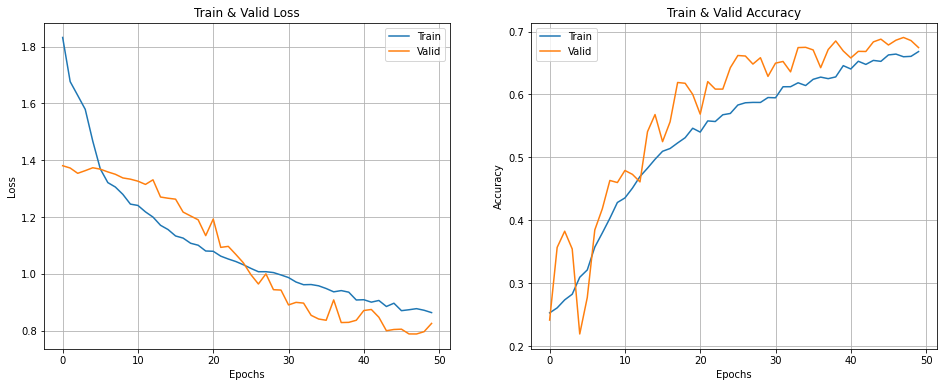

In [ ]:
# Loss & Accuracy : 1번 훈련
draw_graph(hist_V16_base)

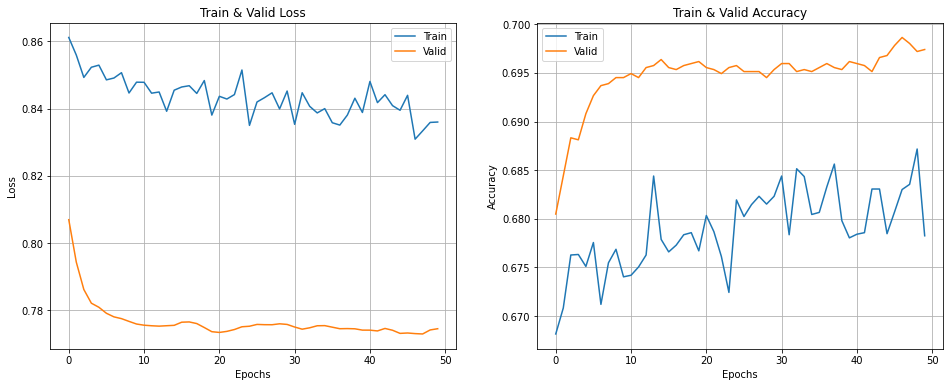

In [ ]:
# Loss & Accuracy : 2번 훈련
draw_graph(hist_V16)

In [ ]:
loss_V16, acc_V16 , pre_V16, rec_V16 = model_V16.evaluate(valid_data)

#f1_score
f1_V16 = (2 * pre_V16 * rec_V16 / (pre_V16 + rec_V16))

print('\n* Loss')
print(f'==> {loss_V16:.5f}')

print('\n* Accuracy')
print(f'==> {acc_V16:.5f}')

print('\n* Precision')
print(f'==> {pre_V16:.5f}')

print('\n* Recall')
print(f'==> {rec_V16:.5f}')

print('\n* F1 Score') 
print(f'==> { f1_V16:.5f}')

5/5 [==============================] - 1s 237ms/step - loss: 0.7745 - accuracy: 0.6974 - precision: 0.7759 - recall: 0.5807

* Loss
==> 0.77450

* Accuracy
==> 0.69740

* Precision
==> 0.77591

* Recall
==> 0.58065

* F1 Score
==> 0.66423


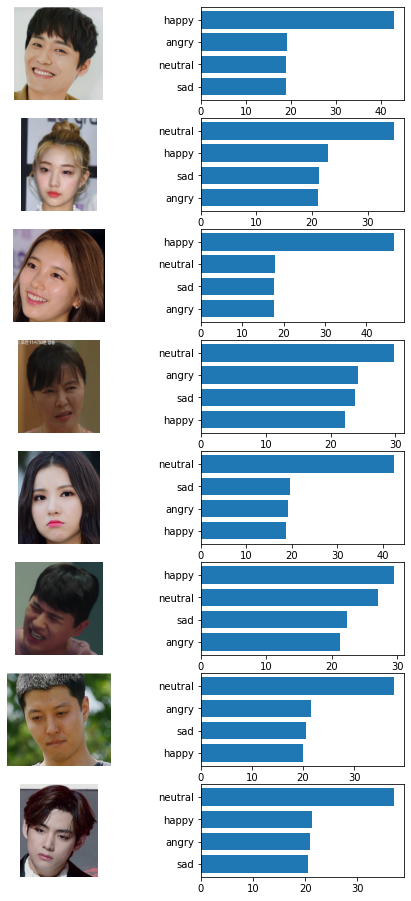

In [ ]:
evaluate_testdata(model_V16)

In [ ]:
#model_V16.save(f'/content/drive/My Drive/[양재] 1조/models/emotion_V16.h5')
#
#model_V16_json = model_V16.to_json()
#with open(f'/content/drive/My Drive/[양재] 1조/models/emotion_V16.json', 'w') as json_file : 
#    json_file.write(model_V16_json)

## VGG19

### Modeling

In [ ]:
from keras.applications.vgg19 import VGG19
from keras import models, layers, optimizers, applications, regularizers

#학습순서
# test파일처럼 모델을 전체 재학습하여 가중치를 저장 => 이어서 앞부분 conv층 얼린 후 후반 layer만 unfreezing상태로 재학습 

#VGG19 기본모델 불러오기
base_model_VGG19 = VGG19(input_shape=(48, 48, 3),
                         include_top=False)

#기본모델 layer 전체 unfreezing하여 재학습
for layer in base_model_VGG19.layers :
    layer.trainable = True

#DNN
model_V19 = models.Sequential()
model_V19.add(base_model_VGG19)
model_V19.add(layers.Flatten())
model_V19.add(layers.Dense(256, activation='relu'))
model_V19.add(layers.Dense(128, activation='relu'))
model_V19.add(layers.Dense(64, activation='relu'))
model_V19.add(layers.Dropout(0.4))
model_V19.add(layers.Dense(32, activation='relu'))
model_V19.add(layers.Dropout(0.4))
model_V19.add(layers.BatchNormalization())
model_V19.add(layers.Dense(4, activation  ='softmax'))

#1번 훈련 : test와 동일
model_V19.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.00001),
              metrics = ['accuracy'])

hist_V19_base = model_V19.fit(train_data,
                              epochs = 50,
                              validation_data = valid_data)

#2번 훈련 : 마지막 층만 녹여서 훈련(finetuning)
for layer in model_V19.layers[0].layers :
    if layer.name.startswith('block5') : layer.trainable = True
    else : layer.trainable = False

model_V19.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.0000001),
              metrics = ['accuracy', 'Precision','Recall'])

hist_V19 = model_V19.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

Epoch 1/50
19/19 [==============================] - 27s 1s/step - loss: 1.8571 - accuracy: 0.2601 - val_loss: 1.3967 - val_accuracy: 0.2397
Epoch 2/50
19/19 [==============================] - 24s 1s/step - loss: 1.8265 - accuracy: 0.2565 - val_loss: 1.3778 - val_accuracy: 0.2628
Epoch 3/50
19/19 [==============================] - 24s 1s/step - loss: 1.7558 - accuracy: 0.2662 - val_loss: 1.3699 - val_accuracy: 0.2739
Epoch 4/50
19/19 [==============================] - 24s 1s/step - loss: 1.7140 - accuracy: 0.2703 - val_loss: 1.3701 - val_accuracy: 0.2902
Epoch 5/50
19/19 [==============================] - 24s 1s/step - loss: 1.6940 - accuracy: 0.2767 - val_loss: 1.3442 - val_accuracy: 0.3426
Epoch 6/50
19/19 [==============================] - 24s 1s/step - loss: 1.6689 - accuracy: 0.2762 - val_loss: 1.3610 - val_accuracy: 0.3086
Epoch 7/50
19/19 [==============================] - 24s 1s/step - loss: 1.6386 - accuracy: 0.2799 - val_loss: 1.3148 - val_accuracy: 0.3938
Epoch 8/50
19/19 [==

### Evaluation

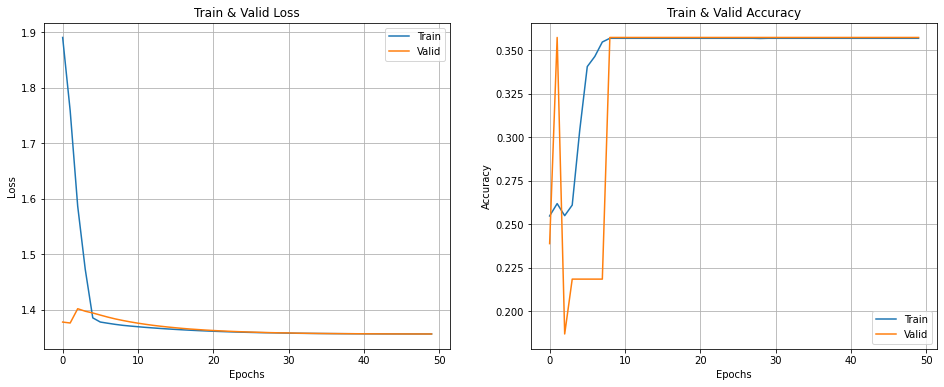

In [ ]:
## Loss & Accuracy : 1번 훈련
draw_graph(hist_V19_base)

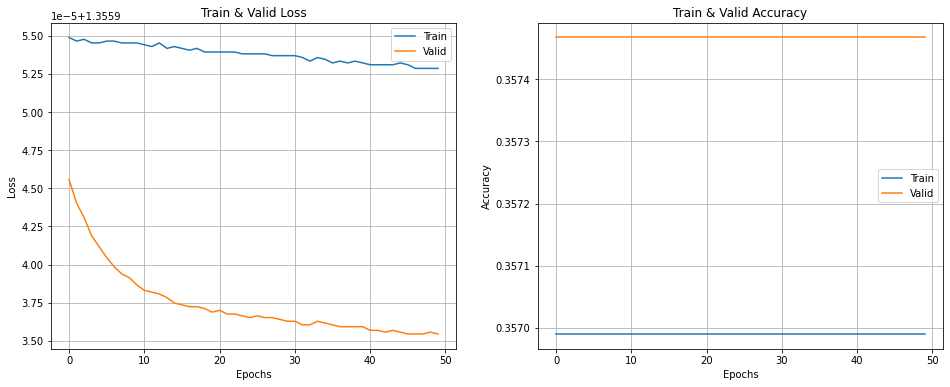

In [ ]:
## Loss & Accuracy : 2번 훈련
draw_graph(hist_V19)

In [ ]:
loss_V19, acc_V19 , pre_V19, rec_V19 = model_V19.evaluate(valid_data)

#f1_score
f1_V19 = (2 * pre_V19 * rec_V19 / (pre_V19 + rec_V19))

print('\n* Loss')
print(f'==> {loss_V19:.5f}')

print('\n* Accuracy')
print(f'==> {acc_V19:.5f}')

print('\n* Precision')
print(f'==> {pre_V19:.5f}')

print('\n* Recall')
print(f'==> {rec_V19:.5f}')

print('\n* F1 Score') 
print(f'==> { f1_V19:.5f}')

5/5 [==============================] - 1s 245ms/step - loss: 0.7698 - accuracy: 0.6871 - precision: 0.7680 - recall: 0.5988

* Loss
==> 0.76982

* Accuracy
==> 0.68709

* Precision
==> 0.76799

* Recall
==> 0.59880

* F1 Score
==> 0.67293


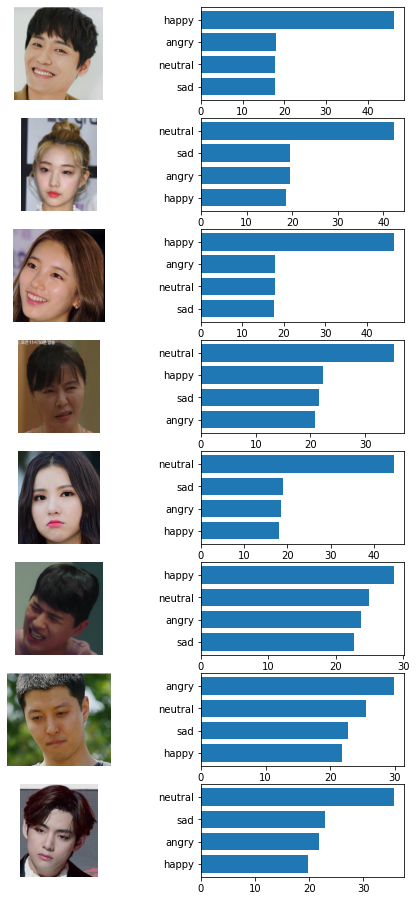

In [ ]:
evaluate_testdata(model_V19)

In [ ]:
#model_V19.save(f'/content/drive/My Drive/[양재] 1조/models/emotion_V19.h5')

#model_V19_json = model_V19.to_json()
#with open(f'/content/drive/My Drive/[양재] 1조/models/emotion_V19.json', 'w') as json_file : 
#    json_file.write(model_V19_json)

## DenseNet169

### Modeling

In [ ]:
from keras.applications.densenet import DenseNet169
from keras import models, layers, optimizers, applications, regularizers

#학습순서
# test파일처럼 모델을 전체 재학습하여 가중치를 저장 => 이어서 앞부분 conv층 얼린 후 후반 layer만 unfreezing상태로 재학습 

#DenseNet169 기본모델 불러오기
base_model_DenseNet169 = DenseNet169(input_shape=(48, 48, 3),
                         include_top=False)

#기본모델 layer 전체 unfreezing하여 재학습
for layer in base_model_DenseNet169.layers :
    layer.trainable = True

#DNN
model_D169 = models.Sequential()
model_D169.add(base_model_DenseNet169)
model_D169.add(layers.Flatten())
model_D169.add(layers.Dense(256, activation='relu'))
model_D169.add(layers.Dropout(0.4))
model_D169.add(layers.Dense(128, activation='relu'))
model_D169.add(layers.Dropout(0.4))
model_D169.add(layers.BatchNormalization())
model_D169.add(layers.Dense(4, activation  ='softmax'))

#1번 훈련 : test와 동일
model_D169.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.0005),
              metrics = ['accuracy'])

hist_D169_base = model_D169.fit(train_data,
                              epochs = 50,
                              validation_data = valid_data)

#2번 훈련 : 마지막 층만 녹여서 훈련(finetuning)
for layer in model_D169.layers[0].layers :
    if layer.name.startswith('conv5') : layer.trainable = True
    else : layer.trainable = False

model_D169.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.00001),
              metrics = ['accuracy', 'Precision','Recall'])

hist_D169 = model_D169.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

51888128/51877672 [==============================] - 1s 0us/step
Epoch 1/50
19/19 [==============================] - 87s 2s/step - loss: 1.6945 - accuracy: 0.2682 - val_loss: 5.2417 - val_accuracy: 0.2422
Epoch 2/50
19/19 [==============================] - 24s 1s/step - loss: 1.4967 - accuracy: 0.2927 - val_loss: 4.1219 - val_accuracy: 0.2325
Epoch 3/50
19/19 [==============================] - 24s 1s/step - loss: 1.4583 - accuracy: 0.3355 - val_loss: 1.7999 - val_accuracy: 0.2457
Epoch 4/50
19/19 [==============================] - 24s 1s/step - loss: 1.4643 - accuracy: 0.3361 - val_loss: 1.3490 - val_accuracy: 0.3624
Epoch 5/50
19/19 [==============================] - 24s 1s/step - loss: 1.4208 - accuracy: 0.3551 - val_loss: 1.3474 - val_accuracy: 0.3575
Epoch 6/50
19/19 [==============================] - 24s 1s/step - loss: 1.3912 - accuracy: 0.3753 - val_loss: 1.3330 - val_accuracy: 0.3575
Epoch 7/50
19/19 [==============================] - 24s 1s/step - loss: 1.3588 - accuracy: 0.40

### Evaluation

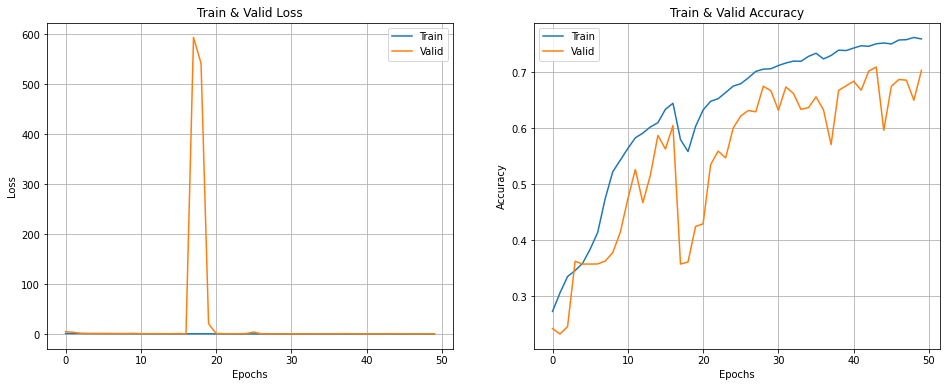

In [ ]:
## Loss & Accuracy : 1번 훈련
draw_graph(hist_D169_base)

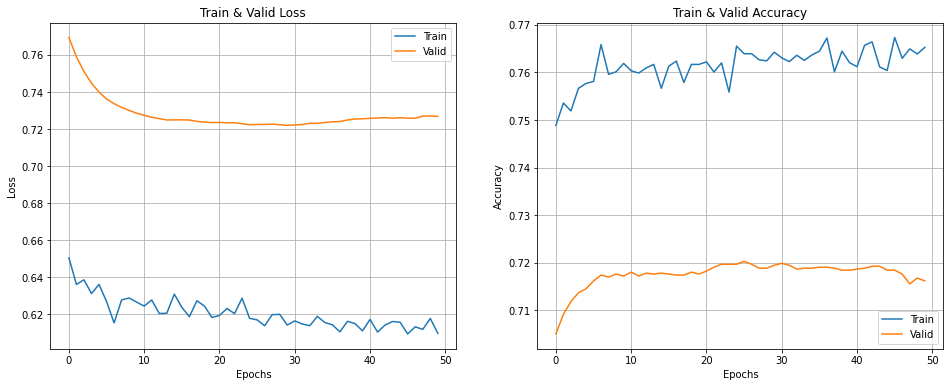

In [ ]:
## Loss & Accuracy : 2번 훈련
draw_graph(hist_D169)

In [ ]:
loss_D169, acc_D169 , pre_D169, rec_D169 = model_D169.evaluate(valid_data)

#f1_score
f1_D169 = (2 * pre_D169 * rec_D169 / (pre_D169 + rec_D169))

print('\n* Loss')
print(f'==> {loss_D169:.5f}')

print('\n* Accuracy')
print(f'==> {acc_D169:.5f}')

print('\n* Precision')
print(f'==> {pre_D169:.5f}')

print('\n* Recall')
print(f'==> {rec_D169:.5f}')

print('\n* F1 Score') 
print(f'==> { f1_D169:.5f}')

5/5 [==============================] - 1s 245ms/step - loss: 0.7268 - accuracy: 0.7162 - precision: 0.7627 - recall: 0.6638

* Loss
==> 0.72681

* Accuracy
==> 0.71617

* Precision
==> 0.76274

* Recall
==> 0.66378

* F1 Score
==> 0.70983


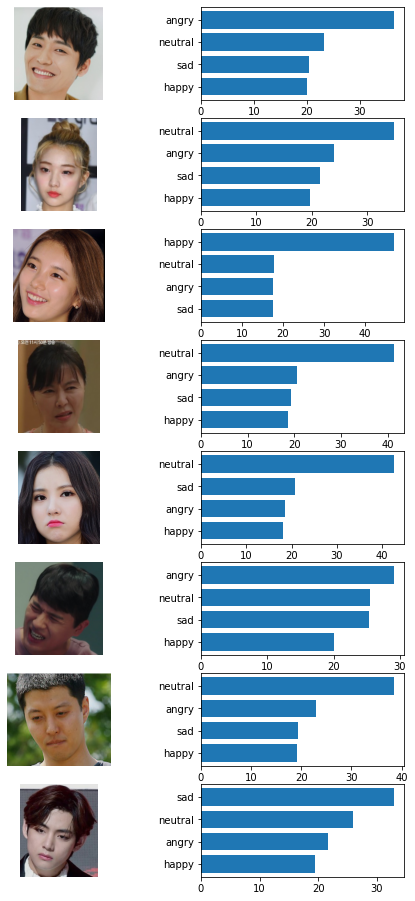

In [ ]:
evaluate_testdata(model_D169)

In [ ]:
##Model save
#model_D169.save('/content/drive/My Drive/[양재] 1조/models/emotion_D169.h5')

##모델 json으로 저장
#model_D169_json = model_D169.to_json()
#with open("/content/drive/My Drive/[양재] 1조/models/emotion_D169.json", "w") as json_file :
#    json_file.write(model_D169_json)

## Result


In [ ]:
import pandas as pd

result = pd.DataFrame(data = {'Name' : ['VGG16','VGG19','DenseNet169'],
                              'Accuracy' : [acc_V16, acc_V19, acc_D169]})

result = result.sort_values(by = ['Accuracy'], ascending = False)
result

,Name,Accuracy
0,VGG16,0.742987
2,DenseNet169,0.738861
1,VGG19,0.733911


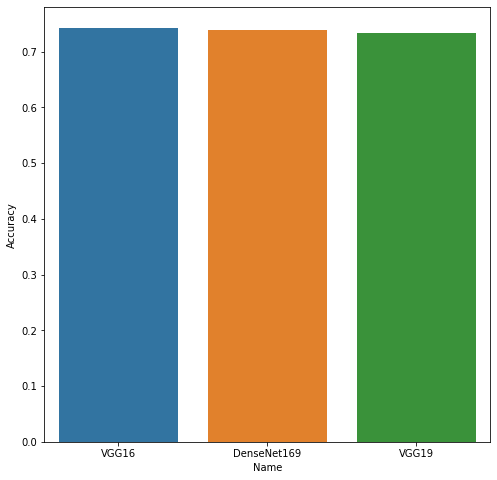

In [ ]:
#Accuracy 순위대로 표시
import seaborn as sns

plt.figure(figsize = (8,8))
sns.barplot(data = result, x = 'Name', y = 'Accuracy')

plt.show()